In [ ]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from scipy import stats
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_log_error as RMSLE

In [ ]:
train = pd.read_csv('../data/merged_train.csv')
test = pd.read_csv('../data/merged_test.csv')

# Fill NaN holiday names with 'None' for consistent string data type along columns
train[['hol_Nat_name','hol_Reg_name','hol_loc_name','hol_event_name']] = train[['hol_Nat_name','hol_Reg_name','hol_loc_name','hol_event_name']].fillna(value='None')
test[['hol_Nat_name','hol_Reg_name','hol_loc_name','hol_event_name']] = test[['hol_Nat_name','hol_Reg_name','hol_loc_name','hol_event_name']].fillna(value='None')


In [ ]:
# Distinguish categorical variables for XGBoost

# categorical: dates, store identifiers, locations, holidays, and product families
# non-categorical: transactions, oil, onpromotion
# target variable: sales

cat_attribs = ['date', 'year', 'month', 'week_number', 'day', 'day_of_week',
       'store_nbr', 'type', 'cluster', 'city', 'state',
       'hol_Nat', 'hol_Nat_name', 'hol_Reg', 'hol_Reg_name', 'hol_Loc',
       'hol_loc_name', 'event', 'hol_event_name', 'transferred',
       'hol_type_Additional', 'hol_type_Bridge', 'hol_type_Event',
       'hol_type_Holiday', 'hol_type_Transfer', 'hol_type_Work Day', 'family']

# Split data by store and product families

In [ ]:
# Create lists of store numbers and product families
stores = range(1,55)
families = list(train.family.unique())

# Create dictionaries to store data by store number and family
train_data = {}
test_data = {}

# Group data by store and family
train_grouped = train.groupby(['store_nbr', 'family'])
test_grouped = test.groupby(['store_nbr','family'])

# Create the nested dictionaries
# e.g. train_data[1]['AUTOMOTIVE'] for rows from store 1 automotive sales
train_data = {
    store: {
        family: train_grouped.get_group((store, family)) 
        for family in families if (store, family) in train_grouped.groups
    }
    for store in stores
}

test_data = {
    store: {
        family: test_grouped.get_group((store, family)) 
        for family in families if (store, family) in test_grouped.groups
    }
    for store in stores
}

# XGBoost on an individual store (to test hyperparameter tuning)

In [ ]:
# Choose your store number and family
single_store = 1
single_family = 'GROCERY I'

In [ ]:
# Create training and validation sets

# Grabs the training data we want and splits into X and y
X = train_data[single_store][single_family]
X_train = X.drop(columns=['transactions','sales'])
y_train = X[['year','month','sales']]

# Define training sets from Jan 1, 2013 to Aug 1, 2017
X_tt = X_train[ (X_train['year']<=2017) & (X_train['month']<8)]
y_tt = y_train[ (y_train['year']<=2017) & (y_train['month']<8)].drop(columns=['year','month'])

# Define validation sets with Aug 1-15, 2017 data
X_val =  X_train[ (X_train['year']==2017) & (X_train['month']>=8)]
y_val = y_train[ (y_train['year']==2017) & (y_train['month']>=8)].drop(columns=['year','month'])

# Cast categorical variables as 'category' type for XGBoost.
X_tt[cat_attribs] = X_tt[cat_attribs].astype('category')
X_val[cat_attribs] = X_val[cat_attribs].astype('category')

In [ ]:
# Hyperparameter tuning using grid search

# Create model
model = xgb.XGBRegressor(enable_categorical=True)

# Define Parameter Grid
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_log_error', cv=3, verbose=1)
# Fit to training data
grid_search.fit(X_tt, y_tt)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


# All stores (simultaneously)

In [ ]:
# Create training and validation sets


# Find index where we split training and validation sets
cutoff = train[ train.date == '2017-08-01' ].first_valid_index()

# Grabs the training data we want and splits into X and y
X_train = X.drop(columns=['transactions','sales'])
y_train = X['sales']
y_train_with_dates = X[['date','sales']]


# Define training sets from Jan 1, 2013 to Aug 1, 2017
# Define validation sets with Aug 1-15, 2017 data
X_tt = X_train.iloc[:cutoff]
X_val =  X_train.iloc[cutoff:]
y_tt = X['sales'].iloc[:cutoff]
y_val =  y_train.iloc[cutoff:]
y_val_with_dates = y_train_with_dates.iloc[cutoff:]

# Cast categorical variables as 'category' type for XGBoost.
X_tt[cat_attribs] = X_tt[cat_attribs].astype('category')
X_val[cat_attribs] = X_val[cat_attribs].astype('category')

In [ ]:
# Make and fit model
model = xgb.XGBRegressor(n_estimators=100, 
                         learning_rate=0.1, 
                         max_depth=9, 
                         enable_categorical=True)
model.fit(X_tt, y_tt)

# Make predictions
predictions = model.predict(X_val)
# Change and negative predictions to 0
predictions = np.clip(predictions, a_min=0, a_max=None)
y_val_with_dates['predictions'] = predictions

# Find RMSLE
print('Root Mean Squared Log Error',RMSLE(y_val_with_dates.sales, y_val_with_dates.predictions))


Root Mean Squared Log Error 0.566889365791511


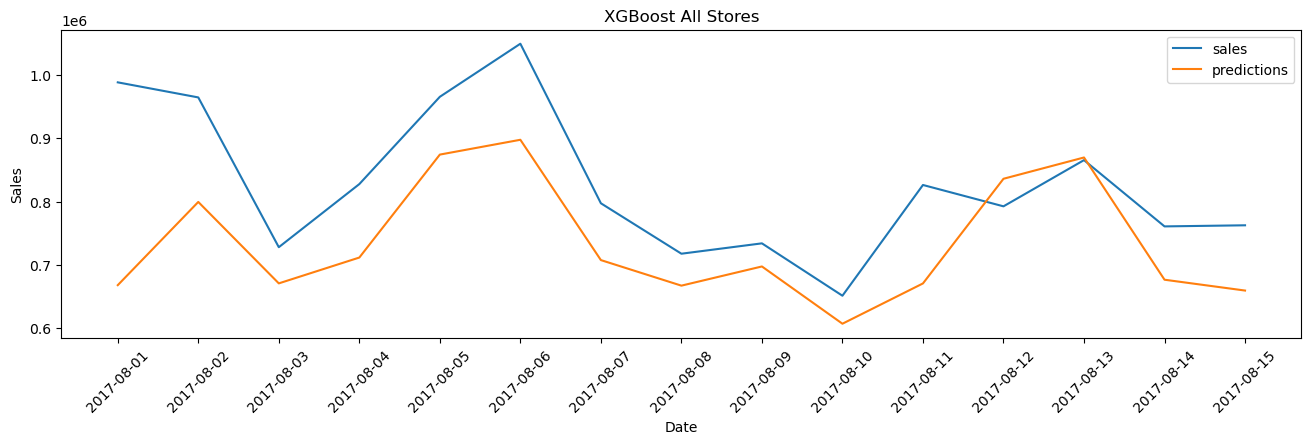

In [ ]:
# Plot total sales and predicted sales for the validation sets

fig = plt.figure(figsize=(16,4))

plt.title(f'XGBoost All Stores')
plt.xlabel('Date')
plt.ylabel('Sales')

plt.plot(range(1,16),
        y_val_with_dates.groupby('date').sum().sales.values,
        label='sales')

plt.plot(range(1,16),
        y_val_with_dates.groupby('date').sum().predictions.values,
        label='predictions')

plt.xticks(ticks=np.arange(1,16),
            labels=y_val_with_dates.groupby('date').sum().index,
            rotation=45)    
plt.legend()
plt.show()

# All Stores (trained individually by store number and family)

In [ ]:
# Create training and validation sets


# Find index where we split training and validation sets
cutoff = train[ train.date == '2017-08-01' ].first_valid_index()

# Partial DataFrame we will use to store predictions.
results = train[['id','date','store_nbr','family','sales']].iloc[cutoff:]

In [ ]:
# Train XGBoost models on each store and product family

for store in stores:
    for family in families:
        
        # Picks data from one store and family, split into X and y
        X = train_data[store][family]
        X_train = X.drop(columns=['transactions','sales'])
        y_train = X[['year','month','sales']]

        # Training sets up to Aug 2017
        X_tt = X_train[ (X_train['year']<=2017) & (X_train['month']<8)]
        y_tt = y_train[ (y_train['year']<=2017) & (y_train['month']<8)].drop(columns=['year','month'])
        # Validation sets from Aug 1-15, 2017
        X_val =  X_train[ (X_train['year']==2017) & (X_train['month']>=8)]
        y_val = y_train[ (y_train['year']==2017) & (y_train['month']>=8)].drop(columns=['year','month'])
        
        # Cast categorical variables for XGBoost.
        X_tt[cat_attribs] = X_tt[cat_attribs].astype('category')
        X_val[cat_attribs] = X_val[cat_attribs].astype('category')
        
        # Make model and fit
        model = xgb.XGBRegressor(n_estimators=200, 
                         learning_rate=0.1, 
                         max_depth=3, 
                         colsample_bytree=0.6,
                         subsample=1,
                         enable_categorical=True)
        model.fit(X_tt, y_tt)

        # Make predictions
        predictions = model.predict(X_val)
        predictions = np.clip(predictions, a_min=0, a_max=None)
        # Find list of id's for rows where we want to add a prediction. Then add them.
        indices_to_fill = results[ (results['store_nbr']==store) & (results['family']==family) ]['id'].index
        
        # Merge predictions to results dataframe along the id's
        results.loc[indices_to_fill, 'predictions'] = predictions
        

In [17]:
results.head()

,id,date,store_nbr,family,sales,predictions
2728374,2974158,2017-08-01,1,AUTOMOTIVE,5.0,3.080547
2728375,2974159,2017-08-01,1,BABY CARE,0.0,0.000000
2728376,2974160,2017-08-01,1,BEAUTY,4.0,1.711641
2728377,2974161,2017-08-01,1,BEVERAGES,2627.0,2035.229614
2728378,2974162,2017-08-01,1,BOOKS,0.0,0.170629


In [19]:
# Create dates for validation set
dates = pd.Series(pd.date_range(start='8/1/2017', end='8/15/2017',freq='D')).astype('str')

# Compute total sales and predicted sales by date
sales = results.groupby('date')['sales'].sum()
predictions = results.groupby('date')['predictions'].sum()

# Compute RMSLE
print('RMSLE:',RMSLE(sales,predictions))

RMSLE: 0.14887486951615644


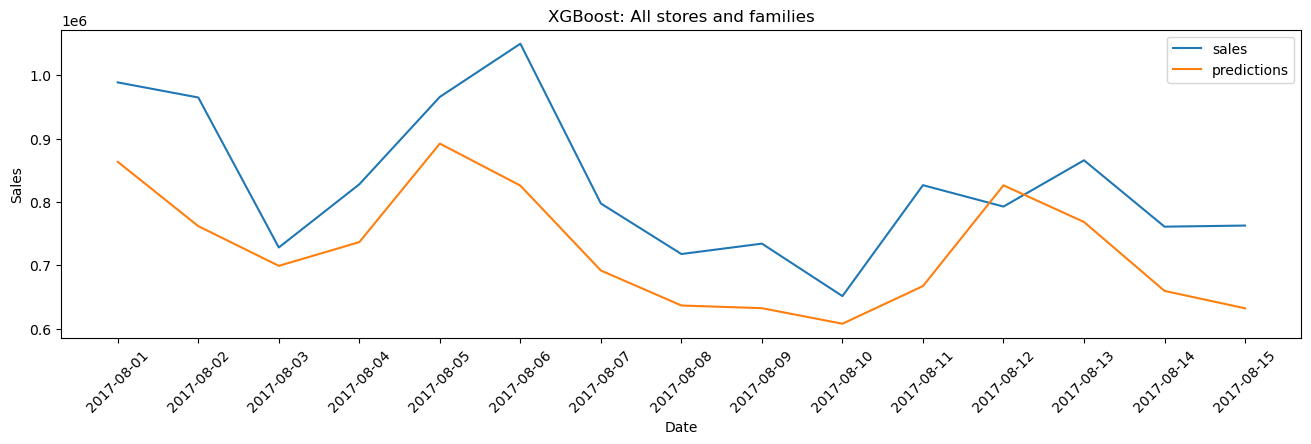

In [20]:
# Plot total sales and predicted sales

fig,ax = plt.subplots(figsize=(16,4))


ax.set_title('XGBoost: All stores and families')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

ax.plot(dates,sales,
        label='sales')

ax.plot(dates,predictions,
        label='predictions')

ax.set_xticks(ticks=dates,labels=dates, rotation=45)

ax.legend()
plt.show()

# Prediction on Test Set

In [24]:
test_results = test[['id','date','store_nbr','family']]

In [ ]:
# Train XGBoost models on each store and product family

for store in stores:
    for family in families:
        
        # Picks data from one store and family, split into training X and y
        X = train_data[store][family]
        X_train = X.drop(columns=['transactions','sales'])
        y_train = X[['sales']]

        # Picks data from one store and family, split into testing X and y
        Z = test_data[store][family]
        X_test = Z.drop(columns=['transactions','sales'])

        
        # Cast categorical variables for XGBoost.
        X_train[cat_attribs] = X_train[cat_attribs].astype('category')
        X_test[cat_attribs] = X_test[cat_attribs].astype('category')
        
        # Make model and fit
        model = xgb.XGBRegressor(n_estimators=200, 
                         learning_rate=0.1, 
                         max_depth=3, 
                         colsample_bytree=0.6,
                         subsample=1,
                         enable_categorical=True)
        model.fit(X_tt, y_tt)

        # Make predictions
        predictions = model.predict(X_test)
        predictions = np.clip(predictions, a_min=0, a_max=None)
        # Find list of id's for rows where we want to add a prediction. Then add them.
        indices_to_fill = test_results[ (test_results['store_nbr']==store) & (test_results['family']==family) ]['id'].index
        
        # Merge predictions to results dataframe along the id's
        test_results.loc[indices_to_fill, 'predictions'] = predictions
        

In [ ]:
submission = test_results.rename(mapper={'predictions':'sales'},axis=1)
submission = submission.drop(columns=['date','store_nbr','family'])
submission

In [ ]:
submission.to_csv("submission.csv", index = False)